# Evaluation of Likelihood using Sequential Monte Carlo

### The particle filter algorithm yields at each step $t$ a weighted sample $(x_t^k, w_t^k)_{k}=1^{N}$ approximating the filtering distribution $p(dx_t|y_{0:t};\theta)$

### The estimators of the marginal liklihood of $\theta$ at time $t$ $$\hat{Z}_t(\theta)=\prod_{s=0}^{t}(\frac{1}{N}\sum_{k=1}^{N}w_s^k)$$

#### p.s:

#### 1.The loaded whisker data is of shape (50,3000), we need to sum it up across axis 0. Then we assume it follows a binomial distribution of N=50.

#### 2.The filtering algorithm in the package returns normalized weights for particle filters, we need to modify it.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [21]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

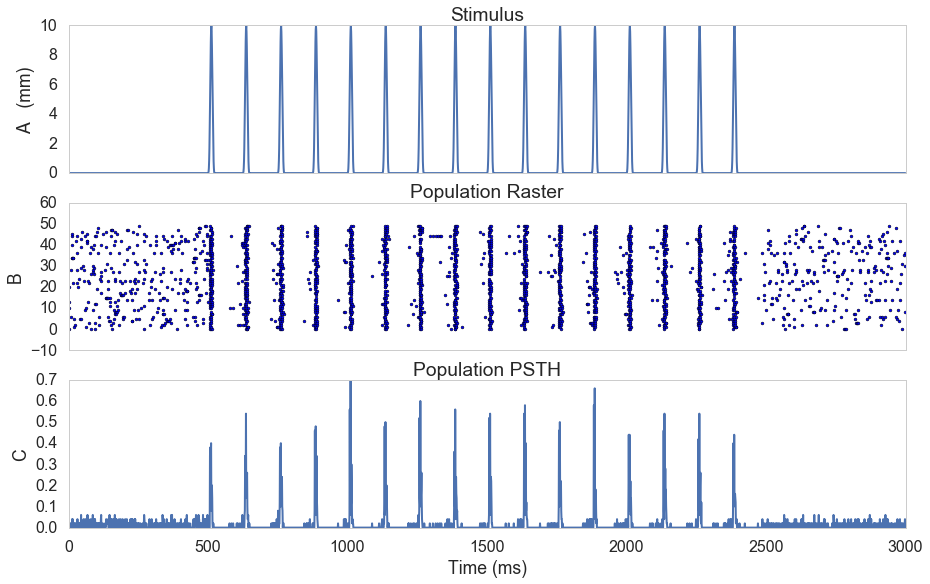

In [22]:
# Get a set of whisker data and plot the raster plot
#path = '/Users/macbookpro/Desktop/Gwungwun/Data/'
path = ""
resp_values_1711 = get_population_data(17,1,1, path = path)
#resp_values_1711 = pickle.load(open('/Users/macbookpro/Documents/ss_model_mixture/resp_values_1711.p','rb'))
plot_raw_data(17,1,1,0,figsize=[15,9],path=path)

resp_values_1711 is the loaded whisker data and it's of shape (50,3000), you need to sum it up across axis 0 and then use the data.

In [23]:
print resp_values_1711.shape
Y = np.sum(resp_values_1711, axis = 0)
print Y.shape

(50, 3000)
(3000,)


initial sigma2e is 0.25

Converged after 77 iterations
sigma2e is  0.505904874894
runtime: 36.3575160503 seconds


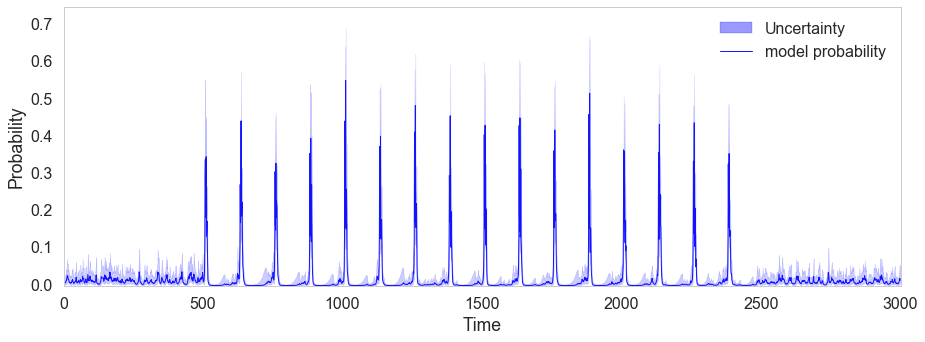

In [6]:
# Run EM on the data set and show results
pmode_1711, p_1711, pll_1711, pul_1711, sigma2e_1711 = RunEM(resp_values_1711)
plot_results(resp_values_1711, pmode_1711, p_1711, pll_1711, pul_1711, ylim=[0,0.75])

In [7]:
print sigma2e_1711

0.505904874894


Create a list of sigmas around `sigma2e_1711`.

In [24]:
sigma_ls = np.arange(sigma2e_1711-0.2, sigma2e_1711+0.2,0.01)
print len(sigma_ls)

40


Now evaluate likelikehood using the list of sigmas. Feel free to play around with the list of sigmas and the step sizes.

We use the nlg.NonlinearGaussianInitialGaussian base class and assume y follows a binomial distribution of $N=50$.

In [25]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
        return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
        lpy = np.empty(N)
        g = self.calc_g(particles=particles, t=t)
 

        if (g is None):
            g = np.repeat(self.g.reshape((1, -1, 1)), N, 0)
        else:
            g = g.reshape((N, -1, 1))
        yrep = np.repeat(np.asarray(y).reshape((1, -1, 1)), N, 0)
        diff = yrep - g
        
        lpy = np.empty(N)
        for i in xrange(N):
            #lpy[i] = bernoulli.logpmf(diff[i],np.exp(particles[i])/(1.0 + np.exp(particles[i])))
            lpy[i] =scipy.stats.binom.logpmf(diff[i],50,np.exp(particles[i])/(1.0 + np.exp(particles[i])),loc=0)
        return lpy

Let simulator return unnormalized weights

In [26]:
class unnormalizedSimulator(simulator.Simulator):
    def get_filtered_estimates(self):
        """
        Returns type (est, w) (must first have called 'simulate')
         - est: (T, N, D) array containing all particles
         - w: (T,D) array containing all particle weights
        T is the length of the dataset, N is the number of particles and
        D is the dimension of each particle
        """

        T = len(self.pt.traj)
        N = self.pt.traj[0].pa.part.shape[0]
        D = self.pt.traj[0].pa.part.shape[1]

        est = np.empty((T, N, D))

        wtmp = np.empty((T, N))

        for t in xrange(T):
            wtmp[t] = np.exp(self.pt.traj[t].pa.w)
            est[t] = self.pt.traj[t].pa.part

        return (est, wtmp)


In [139]:
T = 100
#P0 = 0.5 * np.eye(1)
#Q = 0.4 * np.eye(1)

# Forward particles
N = 100
# Backward trajectories
M = 1

In [140]:
#model = StdNonLin(P0, Q)

#sim = unnormalizedSimulator(model, u=None, y=Y)
#sim.simulate(N, M, filter='PF', smoother='full', meas_first=True)

In [141]:
#(est_filt, w_filt) = sim.get_filtered_estimates()
#w_filt.shape
#np.sum(w_filt, axis = 1)/N

In [142]:
#likelihood=np.sum(np.sum(w_filt, axis = 1)/N)
#print likelihood
#loglikelihood=np.sum(np.log(np.sum(w_filt, axis = 1)/N))
#print loglikelihood

In [143]:
sigma_ls = np.arange(0.01, 0.2, 0.01)

In [144]:
sigma_ls

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19])

In [145]:
df = pd.read_csv('thaldata.csv',header=None)
Y = df.values.reshape(3000)
Y = Y[500:800]
print Y.shape

(300,)


In [150]:
%%time
%%prun
#likelihood=np.empty(len(sigma_ls))
loglikelihood=np.empty(len(sigma_ls))

for i in range(len(sigma_ls)):
    print i,
    P0 = sigma_ls[i] * np.eye(1)
    Q=sigma_ls[i]*np.eye(1)
    model = StdNonLin(P0, Q)
    sim = unnormalizedSimulator(model, u=None, y=Y)
    sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=True)
    (est_filt, w_filt) = sim.get_filtered_estimates()
    loglikelihood[i]=np.sum(np.log(np.sum(w_filt, axis = 1)/N))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 CPU times: user 1min 41s, sys: 455 ms, total: 1min 41s
Wall time: 1min 41s



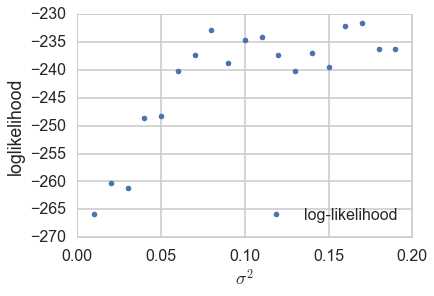

In [151]:
#sigma_ls = np.arange(0.6-0.3, 0.6+0.3+0.01,0.01)
plt.plot(sigma_ls,loglikelihood, '.',linewidth=2.0, label='log-likelihood')
plt.ylabel('loglikelihood')
plt.xlabel(r'$\sigma^2$')
plt.legend(loc='best')

In [43]:
likelihood

array([  2.32799141e-73,   3.64985054e-81,   2.27008238e-76,
         3.00651280e-73,   3.21442064e-71,   7.77464967e-74,
         7.76237527e-69,   2.04873055e-64,   3.67996036e-67])

In [17]:
sigma_ls.shape

(60,)